# 1.) Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('/content/drive/MyDrive/BrainAgeRegression')

In [ ]:
from utils.utils import BrainAgeDataset, set_seed, count_parameters, split_dataset, normalize_targets, denormalize_targets

In [ ]:
from utils.train_utils import BrainAgeTrainer
from utils.eval_utils import BrainAgeEvaluator

In [ ]:
csv_path = '/content/drive/MyDrive/BrainAgeRegression/matched_metadata.csv'
df = pd.read_csv(csv_path)

nifti_dir = '/content/drive/MyDrive/BrainAgeRegression/data/nifti'
full_dataset = BrainAgeDataset(df, nifti_dir)


In [ ]:
sys.path.append('/content/drive/MyDrive/BrainAgeRegression/models')

In [ ]:
from cnn3d import Simple3DCNN

# 2.) Normalize Data

In [ ]:
df, mean_age, std_age = normalize_targets(df, target_col='Age')
full_dataset = BrainAgeDataset(df, nifti_dir, use_normalized_age=True)

# 2.) Train/Test/Val Split

In [ ]:
train_dataset, val_dataset, test_dataset = split_dataset(full_dataset)

In [ ]:
print(f"📊 Train size: {len(train_dataset)}")
print(f"📊 Val size:   {len(val_dataset)}")
print(f"📊 Test size:  {len(test_dataset)}")

📊 Train size: 101
📊 Val size:   12
📊 Test size:  14


# 3.) Initialize our Model and Components

In [ ]:
model = Simple3DCNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(model)

Simple3DCNN(
  (net): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=402688, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)


# 4.) Create our DataLoaders

In [ ]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

# 5.) Training Loop

In [ ]:
trainer = BrainAgeTrainer(model, train_loader, val_loader, criterion, optimizer, device)
trainer.train(epochs=10, track_predictions=True)

history = trainer.get_history()
train_pred, train_true = trainer.get_predictions()['train']
val_pred, val_true = trainer.get_predictions()['val']

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


📅 Epoch 1/10 | 🏋️ Train Loss: 1480.6350 | 🧪 Val Loss: 1003.4822
📅 Epoch 2/10 | 🏋️ Train Loss: 629.0556 | 🧪 Val Loss: 538.0931
📅 Epoch 3/10 | 🏋️ Train Loss: 568.7416 | 🧪 Val Loss: 450.4539
📅 Epoch 4/10 | 🏋️ Train Loss: 549.9189 | 🧪 Val Loss: 616.5065
📅 Epoch 5/10 | 🏋️ Train Loss: 483.5279 | 🧪 Val Loss: 443.8248
📅 Epoch 6/10 | 🏋️ Train Loss: 462.9273 | 🧪 Val Loss: 260.7815
📅 Epoch 7/10 | 🏋️ Train Loss: 399.2881 | 🧪 Val Loss: 171.7956
📅 Epoch 8/10 | 🏋️ Train Loss: 322.3727 | 🧪 Val Loss: 169.0234
📅 Epoch 9/10 | 🏋️ Train Loss: 258.8787 | 🧪 Val Loss: 231.6451
📅 Epoch 10/10 | 🏋️ Train Loss: 260.2634 | 🧪 Val Loss: 294.0706


# 6.) Test Eval

In [ ]:
evaluator = BrainAgeEvaluator(model, device)
metrics, y_pred, y_true = evaluator.evaluate(test_loader, criterion)

print(f"📏 MAE: {metrics['mae']:.2f} | R²: {metrics['r2']:.3f} | RMSE: {metrics['rmse']:.2f}")

📏 MAE: 12.50 | R²: 0.636 | RMSE: 13.90


# 7.) Evaluate our Model

/content/drive/MyDrive/BrainAgeRegression/utils/eval_utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


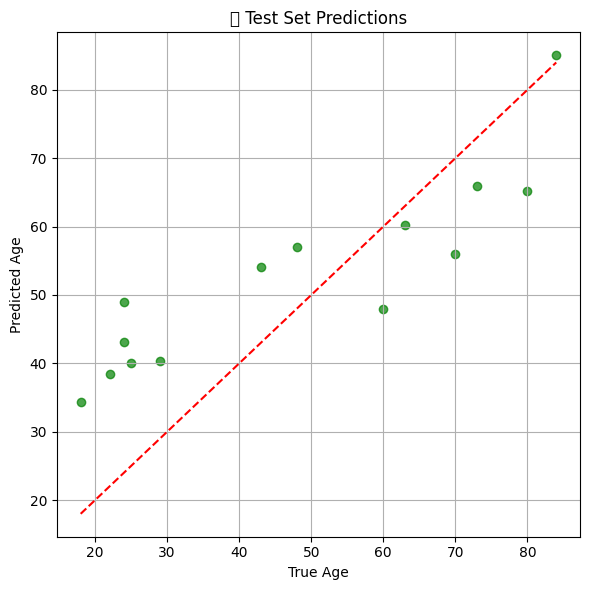

/content/drive/MyDrive/BrainAgeRegression/utils/eval_utils.py:61: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


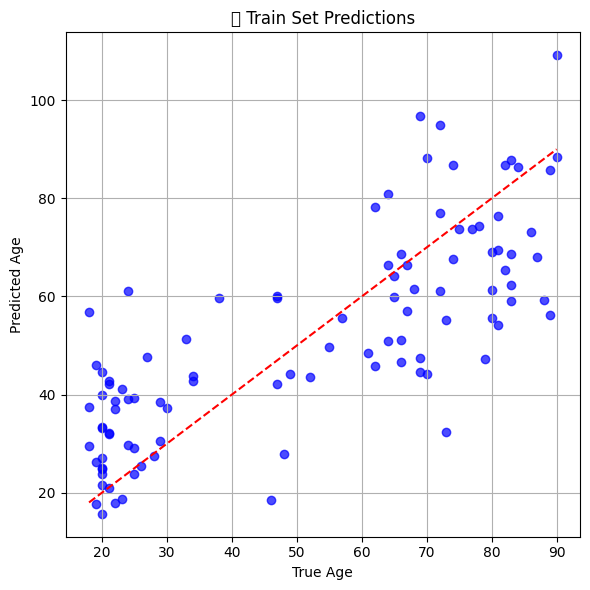

In [ ]:
evaluator.plot_predictions(y_true, y_pred, title="🧪 Test Set Predictions", color='green')
evaluator.plot_predictions(train_true, train_pred, title="🏋️ Train Set Predictions", color='blue')

/tmp/ipython-input-17-3889346936.py:19: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-17-3889346936.py:19: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-17-3889346936.py:19: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


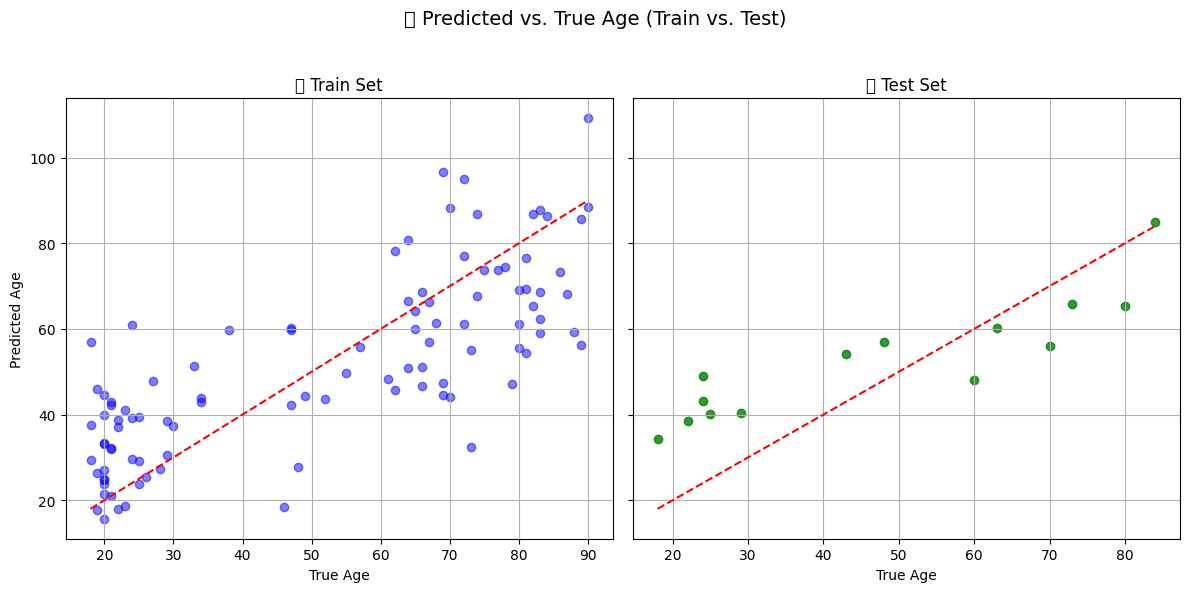

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Train plot
axes[0].scatter(train_true, train_pred, alpha=0.5, color='blue')
axes[0].plot([min(train_true), max(train_true)], [min(train_true), max(train_true)], 'r--')
axes[0].set_title("🏋️ Train Set")
axes[0].set_xlabel("True Age")
axes[0].set_ylabel("Predicted Age")
axes[0].grid(True)

# Test plot
axes[1].scatter(y_true, y_pred, alpha=0.8, color='green')
axes[1].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
axes[1].set_title("🧪 Test Set")
axes[1].set_xlabel("True Age")
axes[1].grid(True)

plt.suptitle("🧠 Predicted vs. True Age (Train vs. Test)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
